Struttura del notebook

3. Suddivisione e Scaling
    - Separazione dei dati in set di addestramento e test.
    - Standardizzazione dei dati numerici.
    - Controllo della suddivisione e scaling.

4. Addestramento e Valutazione del Modello
    - Selezione e addestramento del modello (e.g., Random Forest, Regressione Logistica).
    - Valutazione delle performance del modello (accuratezza, precisione, recall).
    - Tuning degli iperparametri.

5. Conclusioni e Passi Successivi
    - Riepilogo dei risultati e performance.
    - Conclusioni.


## Install and Import Libraries

In [15]:
!pip install pandas numpy scikit-learn imblearn seaborn shap matplotlib xgboost scipy pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [16]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import matplotlib.pyplot as plt
import pickle

# Split Data & Scaling

In [17]:
dataset_path = '../dataset/preprocessed_data.csv'
df = pd.read_csv(dataset_path)

X = df.drop(columns=['risk_level'])
y = df['risk_level']

In [18]:
# Eseguiamo il primo train-test split con stratificazione per ottenere il 10% dei dati

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Si scala le caratteristiche in modo che siano normalizzate con media zero. Questo passaggio è consigliato per le SVM e modelli lineari, poiché facilita l'adattamento del modello. Considerata la presenza di outlier, si è optato per utilizzare uno StandardScaler anziché un MinMaxScaler

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

## Bilanciamento con UnderSampling

In [21]:
print("\nDistribuzione delle classi prima di SMOTE:")
print(Counter(y_train))


Distribuzione delle classi prima di SMOTE:
Counter({0.0: 654128, 1.0: 46442})


In [22]:
undSampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train, y_train = undSampler.fit_resample(X_train, y_train)

In [23]:
print("\nDistribuzione delle classi dopo SMOTE:")
print(Counter(y_train))


Distribuzione delle classi dopo SMOTE:
Counter({0.0: 46442, 1.0: 46442})


## Correlation

In [24]:
correlation_matrix = df.corr()
correlation_matrix

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,annual_inc,verification_status,dti,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,risk_level
loan_amnt,1.000000,0.999422,0.975037,0.425341,0.126403,0.962657,-0.138916,0.312712,0.271784,0.048787,...,-0.000080,-0.064470,-0.078643,-0.076403,-0.153322,-0.017649,0.005338,-0.091379,-0.027198,0.000302
funded_amnt,0.999422,1.000000,0.975794,0.424549,0.126679,0.963531,-0.138826,0.312503,0.271722,0.049544,...,-0.000253,-0.064721,-0.078693,-0.076479,-0.153564,-0.017733,0.004407,-0.091394,-0.027553,-0.000337
funded_amnt_inv,0.975037,0.975794,1.000000,0.411118,0.145761,0.935050,-0.157769,0.332125,0.280681,0.045123,...,0.000435,-0.052881,-0.066795,-0.063702,-0.129647,-0.014910,0.005126,-0.073297,-0.027416,-0.002579
term,0.425341,0.424549,0.411118,1.000000,0.428490,0.196233,-0.454685,0.058702,0.195266,0.106791,...,-0.000579,-0.016610,-0.024689,-0.027660,-0.046018,-0.006774,-0.005983,-0.034216,-0.014658,0.037824
int_rate,0.126403,0.126679,0.145761,0.428490,1.000000,0.123954,-0.978592,-0.072729,0.218977,0.163685,...,0.041155,-0.018545,0.029716,0.044577,0.092117,0.012575,0.073992,0.018686,0.010435,0.167998
installment,0.962657,0.963531,0.935050,0.196233,0.123954,1.000000,-0.126621,0.305985,0.258448,0.039895,...,0.004953,-0.067910,-0.076185,-0.071845,-0.144862,-0.016172,0.016014,-0.089781,-0.024011,0.009882
sub_grade,-0.138916,-0.138826,-0.157769,-0.454685,-0.978592,-0.126621,1.000000,0.065883,-0.224829,-0.176943,...,-0.041074,0.017251,-0.031002,-0.046129,-0.094443,-0.013124,-0.076741,-0.019231,-0.005821,-0.142647
annual_inc,0.312712,0.312503,0.332125,0.058702,-0.072729,0.305985,0.065883,1.000000,0.084170,-0.177901,...,0.005586,0.003889,-0.004195,-0.008150,-0.018477,-0.000617,0.024408,-0.009128,-0.004319,-0.036709
verification_status,0.271784,0.271722,0.280681,0.195266,0.218977,0.258448,-0.224829,0.084170,1.000000,0.072563,...,0.007533,-0.024601,-0.013693,-0.010680,-0.010747,0.000820,0.028718,-0.010385,-0.011936,0.023699
dti,0.048787,0.049544,0.045123,0.106791,0.163685,0.039895,-0.176943,-0.177901,0.072563,1.000000,...,-0.029192,-0.059916,-0.010793,-0.018553,-0.034582,-0.007374,-0.053310,-0.008682,-0.025457,0.018858


Alta correlazione tra molte delle caratteristiche è un'indicazione che l'uso di tecniche di riduzione della dimensionalità potrebbe essere vantaggioso.

# Feature Reduction

In [25]:
pca = PCA(n_components=len(X_train.columns))
pca.fit(X_train)

PCA(n_components=53, random_state=42)

In [26]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

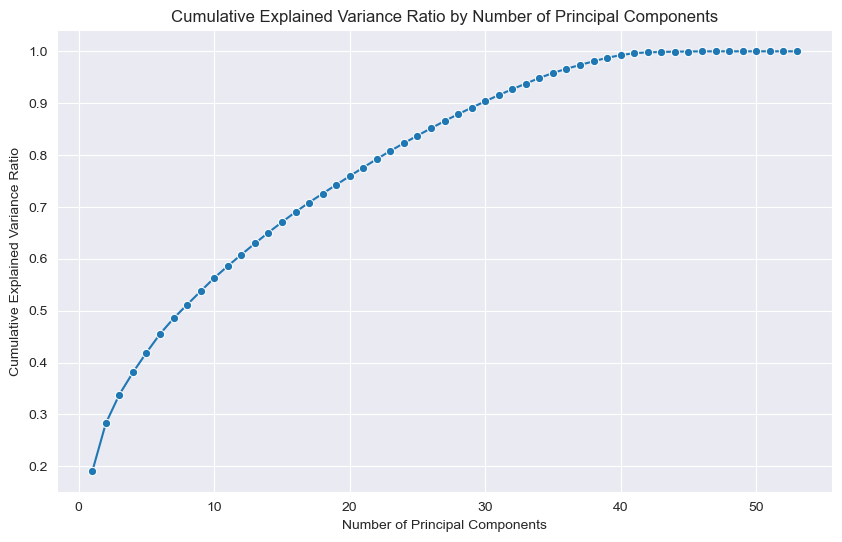

In [27]:
# Create a DataFrame for cumulative explained variance ratio
cvr = pd.DataFrame({
    'Number of Principal Components': range(1, len(cumulative_variance) + 1),
    'Cumulative Explained Variance Ratio': cumulative_variance
})

# Set up the figure
plt.figure(figsize=(10, 6))

# Create the line plot using Seaborn
sns.lineplot(data=cvr, 
             x='Number of Principal Components', 
             y='Cumulative Explained Variance Ratio', 
             marker='o')  # Adding markers for clarity

# Add title and labels
plt.title('Cumulative Explained Variance Ratio by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')

# Add grid lines for better readability
plt.grid(True)

# Show the figure
plt.show()

In [28]:
X_train.shape

(92884, 53)

In [14]:
components_to_retain = np.argmax(cumulative_variance >= 0.9) + 1
pca = PCA(n_components=components_to_retain)

X_train_copy = X_train

X_train = pca.fit_transform(X_train)

X_test_copy = X_test

X_test = pca.transform(X_test)
components_to_retain

30

In [31]:
X_train.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,annual_inc,verification_status,dti,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
588357,-2.355343,-2.355897,-1.565348,-0.655419,1.051057,-2.436047,-1.242748,-0.461074,0.652305,-0.519888,...,-0.248822,-0.06464,-0.140976,-0.098612,-0.078162,-0.224136,-0.024983,-0.108383,-0.073349,-0.050839
359582,-1.202691,-1.201797,-1.091017,-0.655419,-0.515899,-1.164098,0.454347,-0.768104,0.652305,1.617927,...,-0.248822,-0.06464,-0.140976,-0.098612,-0.078162,-0.224136,-0.024983,-0.108383,-0.073349,-0.050839
398394,-1.314825,-1.314034,-1.153273,-0.655419,1.322480,-1.145780,-1.088467,-0.169395,-1.533025,0.530330,...,-0.248822,-0.06464,-0.140976,-0.098612,-0.078162,4.461577,-0.024983,-0.108383,-0.073349,-0.050839
684338,0.724706,0.726502,0.625467,-0.655419,-0.059725,1.012022,-0.008497,-0.307559,0.652305,0.203569,...,-0.248822,-0.06464,-0.140976,-0.098612,-0.078162,-0.224136,-0.024983,-0.108383,-0.073349,-0.050839
454535,0.814481,0.816285,0.738121,-0.655419,1.194751,1.272713,-0.779904,-0.430371,0.652305,-0.147308,...,-0.248822,-0.06464,-0.140976,-0.098612,-0.078162,-0.224136,-0.024983,-0.108383,-0.073349,-0.050839


## Modeling

### Funzioni di utilità

In [65]:
def save_model(model, filename):
    filename = '../models/smartLending'+'/'+filename
    try:
        with open(filename, 'wb') as file:
            pickle.dump(model, file)
        print(f"Modello salvato con successo in: {filename}")
    except Exception as e:
        print(f"Errore nel salvataggio del modello: {e}")

In [66]:
def save_grid_search_results(results, columns_to_save, filename):
    filename = '../results/smartLending'+'/'+filename

    # Seleziona le colonne principali per il CSV
    results_to_save = results[columns_to_save].copy()

    # Identifica il miglior modello basato su mean_test_score
    best_index = results['mean_test_score'].idxmax()  # Indice del miglior punteggio medio

    # Aggiungi una colonna che indica se il modello è il migliore
    results_to_save['is_best_model'] = False
    results_to_save.loc[best_index, 'is_best_model'] = True


    # Salva i risultati in un file CSV
    results_to_save.to_csv(filename, index=False)
    print(f"Risultati salvati con successo in: {filename}")

In [67]:
def plot_confusion_matrix(y_true, y_pred):
    # Calcola la matrice di confusione
    cm = confusion_matrix(y_true, y_pred)

    # Configura la visualizzazione
    plt.figure(figsize=(8,6))
    class_labels = sorted(set(y_true) | set(y_pred))  # Unisce le classi uniche di y_true e y_pred
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

    # Aggiungi titolo e etichette
    plt.title('Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)

    # Mostra il grafico
    plt.show()

In [68]:
def plot_feature_importance(model, pca, X):
    importances = model.feature_importances_
    pca_loadings = pca.components_

    # The importance of each feature is the sum of the absolute values of its loadings across all components
    feature_importance = np.sum(np.abs(pca_loadings), axis=0)

    # Step 8: Sort the feature importances in descending order
    sorted_idx = np.argsort(feature_importance)[::-1]

    top_sorted_idx = sorted_idx[:28]

    # Step 10: Plot the top 28 feature importances based on original feature names
    plt.figure(figsize=(12, 6))
    plt.bar(range(28), feature_importance[top_sorted_idx])
    plt.title(f'Top {28} Feature Importance')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.xticks(range(28), np.array(X.columns)[top_sorted_idx], rotation=90)  # If X is a DataFrame
    plt.show()

### SVM

In [69]:
#Creo il classificatore SVM
svm = SVC(random_state=42)

# Definisco la griglia di iperparametri
param_grid = {
    'C': [1],                    # Ridotto ai valori più comuni per C
    'kernel': ['linear', 'rbf'], # Mantenuto solo il kernel lineare per semplificare
}

# Utilizzo il Grid Search
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

#  Miglior modello trovato
print("Migliori parametri trovati: ", grid_search.best_params_)
best_svm_model = grid_search.best_estimator_

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Migliori parametri trovati:  {'C': 1, 'kernel': 'rbf'}


In [70]:
# Predico sul set di test
y_pred = best_svm_model.predict(X_test)

#  Report di classificazione
print("Classification report on test set:")
print(classification_report(y_test, y_pred))

Classification report on test set:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    163533
         1.0       0.72      0.77      0.75     11610

    accuracy                           0.97    175143
   macro avg       0.85      0.88      0.86    175143
weighted avg       0.97      0.97      0.97    175143



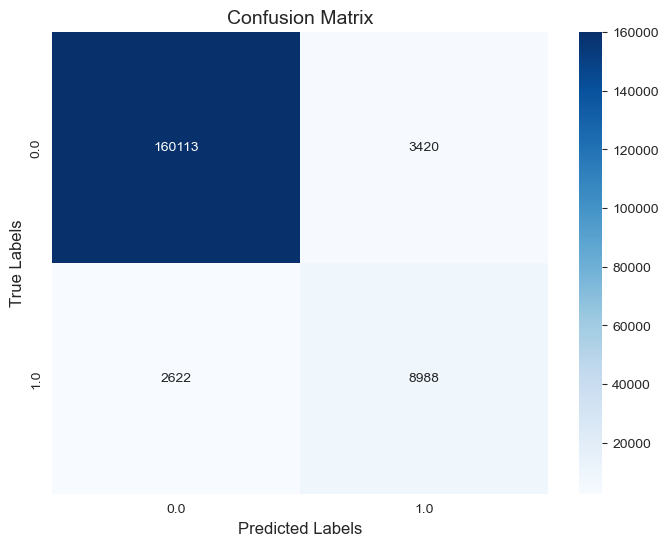

In [71]:
#  Matrice di confusione
plot_confusion_matrix(y_test, y_pred)

In [72]:
#Salvataggio dei risultati
columns_to_save = [
    'param_C', 'param_kernel', # Parametri del modello
    'mean_test_score', 'std_test_score', 'rank_test_score', 'precision', 'recall', 'f1_score', 'accuracy'
]

results = pd.DataFrame(grid_search.cv_results_)
results['precision'] = precision_score(y_test, y_pred, average='weighted')
results['recall'] = recall_score(y_test, y_pred, average='weighted')
results['f1_score'] = f1_score(y_test, y_pred, average='weighted')
results['accuracy'] = accuracy_score(y_test, y_pred)

save_grid_search_results(results, columns_to_save, 'svm_results.csv')

# Salvataggio del miglior modello SVM
save_model(best_svm_model, "best_svm_model_sl.pkl")

Risultati salvati con successo in: ../results/svm_results.csv
Modello salvato con successo in: ../models/best_svm_model.pkl


### Logistic Regression

In [73]:
# Creo il modello Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=500)

# Definisco la griglia di iperparametri
param_grid = {
    'penalty': ['l2'],        # Limitato ai tipi di penalizzazione più comuni
    'C': [0.1, 1, 10],                # Ridotto l'intervallo di valori per C
    'solver': ['lbfgs', 'liblinear'], # Meno solver per velocizzare la ricerca
}

# Grid Search
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='f1_weighted',  # Ottimizzare per F1-score ponderato
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

# Miglior modello trovato
print("Migliori parametri trovati: ", grid_search.best_params_)
best_lr_model = grid_search.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Migliori parametri trovati:  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [74]:
# Predizioni sul set di test
y_pred = best_lr_model.predict(X_test)

# Report di classificazione
print("Classification report on test set:")
print(classification_report(y_test, y_pred))

Classification report on test set:
              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96    163533
         1.0       0.49      0.80      0.61     11610

    accuracy                           0.93    175143
   macro avg       0.74      0.87      0.78    175143
weighted avg       0.95      0.93      0.94    175143



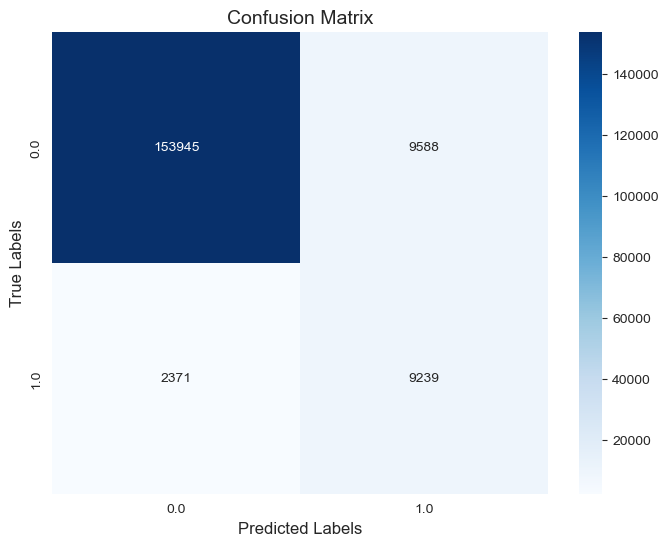

In [75]:
#  Matrice di confusione
plot_confusion_matrix(y_test, y_pred)

In [76]:
#Salvataggio dei risultati
columns_to_save = [
    'param_penalty', 'param_C', 'param_solver',                   # Parametri del modello
    'mean_test_score', 'std_test_score', 'rank_test_score', 'precision', 'recall', 'f1_score', 'accuracy'
]

results = pd.DataFrame(grid_search.cv_results_)
results['precision'] = precision_score(y_test, y_pred, average='weighted')
results['recall'] = recall_score(y_test, y_pred, average='weighted')
results['f1_score'] = f1_score(y_test, y_pred, average='weighted')
results['accuracy'] = accuracy_score(y_test, y_pred)

save_grid_search_results(results, columns_to_save, 'lr_results.csv')

# Salvataggio del miglior modello Logistic Regression
save_model(best_lr_model, "best_lr_model_sl.pkl")

Risultati salvati con successo in: ../results/lr_results.csv
Modello salvato con successo in: ../models/best_lr_model.pkl


### Random Forest


In [77]:
# Creazione il modello Random Forest
rf = RandomForestClassifier(random_state=42)

# Definisco la griglia di iperparametri
param_grid = {
    'n_estimators': [100, 200],          # Numero di alberi (limitato a 100 e 200)
    'max_depth': [5, 7],                # Profondità massima (limitato a 10 e 20)
    'min_samples_leaf': [1, 2],          # Minimo numero di campioni per una foglia (limitato a 1 e 2)
}

# Grid Search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1_weighted',  # Ottimizzare per F1-score ponderato
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 7], 'min_samples_leaf': [1, 2],
                         'n_estimators': [100, 200]},
             scoring='f1_weighted', verbose=2)

In [78]:
# Individuo il  Miglior modello trovato
print("Migliori parametri trovati: ", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

Migliori parametri trovati:  {'max_depth': 7, 'min_samples_leaf': 1, 'n_estimators': 100}


In [79]:
# Predico sul set di test
y_pred = best_rf_model.predict(X_test)

#  Report di classificazione
print("Classification report on test set:")
print(classification_report(y_test, y_pred))

Classification report on test set:
              precision    recall  f1-score   support

         0.0       0.98      0.81      0.89    163533
         1.0       0.22      0.77      0.35     11610

    accuracy                           0.81    175143
   macro avg       0.60      0.79      0.62    175143
weighted avg       0.93      0.81      0.85    175143



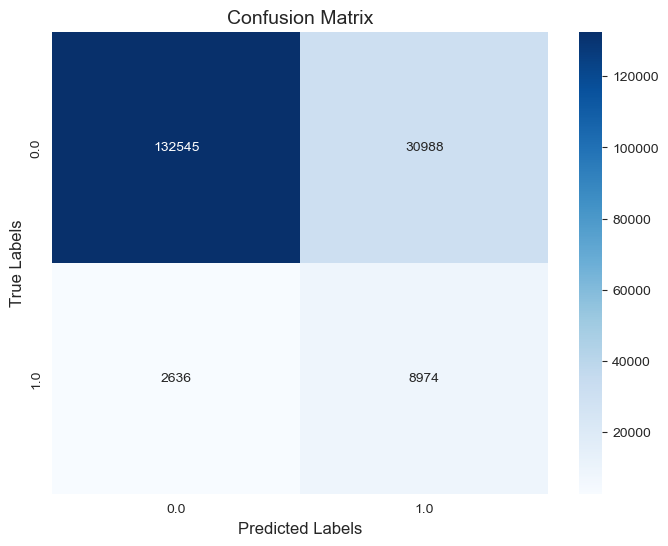

In [80]:
#  Matrice di confusione
plot_confusion_matrix(y_test, y_pred)

In [81]:
#Salvataggio dei risultati
columns_to_save = [
    'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf',  # Parametri del modello
    'mean_test_score', 'std_test_score', 'rank_test_score', 'precision', 'recall', 'f1_score', 'accuracy' #metrics
]

results = pd.DataFrame(grid_search.cv_results_)
results['precision'] = precision_score(y_test, y_pred, average='weighted')
results['recall'] = recall_score(y_test, y_pred, average='weighted')
results['f1_score'] = f1_score(y_test, y_pred, average='weighted')
results['accuracy'] = accuracy_score(y_test, y_pred)

save_grid_search_results(results, columns_to_save, 'rf_results.csv')

# Salvataggio del miglior modello RF
save_model(best_rf_model, "best_rf_model_sl.pkl")

Risultati salvati con successo in: ../results/rf_results.csv
Modello salvato con successo in: ../models/best_rf_model.pkl


### XGBoost

In [82]:
# Creo del modello XGBoost
model = XGBClassifier(
    objective='binary:logistic',  # Per classificazione multiclasse
    random_state=42,
    eval_metric='logloss'      # Specifica la metrica di valutazione
)

# Definizione della griglia di iperparametri
param_grid = {
    'n_estimators': [100, 200],           # Numero di boosting rounds
    'learning_rate': [0.01, 0.1],         # Step size (limitato a 0.01 e 0.1)
    'max_depth': [5, 7],                   # Profondità massima dell'albero (limitato a 3 e 5)
    'subsample': [0.8, 1.0],               # Sottocampione dei dati (limitato a 0.8 e 1.0)
}

#  Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1_weighted',  # Ottimizzare per F1-score ponderato
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

# Miglior modello
print("Migliori parametri trovati: ", grid_search.best_params_)
best_xgb_model = grid_search.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Migliori parametri trovati:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}


In [83]:
#  Predizioni sul set di test
y_pred = best_xgb_model.predict(X_test)

# Report di classificazione
print("Classification report on test set:")
print(classification_report(y_test, y_pred))

Classification report on test set:
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96    163533
         1.0       0.50      0.80      0.61     11610

    accuracy                           0.93    175143
   macro avg       0.74      0.87      0.79    175143
weighted avg       0.95      0.93      0.94    175143



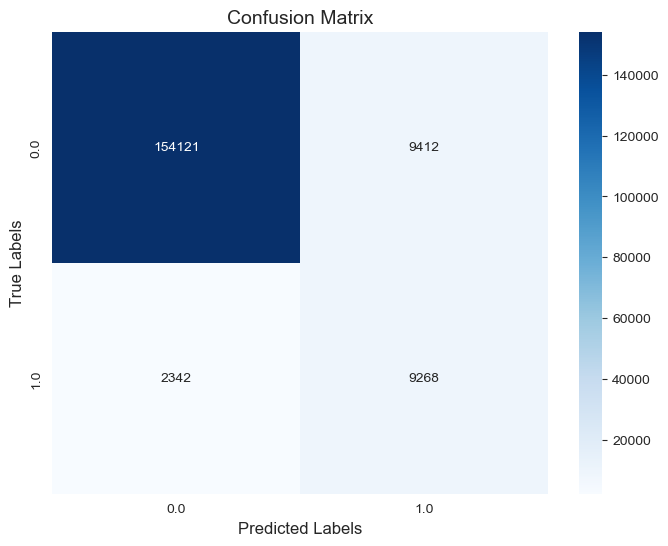

In [84]:
#plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [85]:
#Salvataggio dei risultati
columns_to_save = [
    'param_n_estimators', 'param_learning_rate', 'param_max_depth',
    'param_subsample',
    'mean_test_score', 'std_test_score', 'rank_test_score', 'precision', 'recall', 'f1_score', 'accuracy'
]

results = pd.DataFrame(grid_search.cv_results_)
results['precision'] = precision_score(y_test, y_pred, average='weighted')
results['recall'] = recall_score(y_test, y_pred, average='weighted')
results['f1_score'] = f1_score(y_test, y_pred, average='weighted')
results['accuracy'] = accuracy_score(y_test, y_pred)

save_grid_search_results(results, columns_to_save, 'xgb_results.csv')

# Salvataggio del miglior modello XGBoost
save_model(best_xgb_model, "best_xgb_model_sl.pkl")

Risultati salvati con successo in: ../results/xgb_results.csv
Modello salvato con successo in: ../models/best_xgb_model.pkl


## SHAP
Vediamo adesso la differenza tra il metodo built-in di Random Forest basato sulla riduzione dell'impurità e quello fornito da SHAP che fornisce una misura più raffinata dell'importanza delle caratteristiche, prendendo in considerazione le interazioni e considerando ogni possibile combinazione di caratteristiche, rendendo il modello più interpretabile e accurato.

In [87]:
best_rf_model = pickle.load(open('../models/smartLending/best_rf_model.pkl', 'rb'))

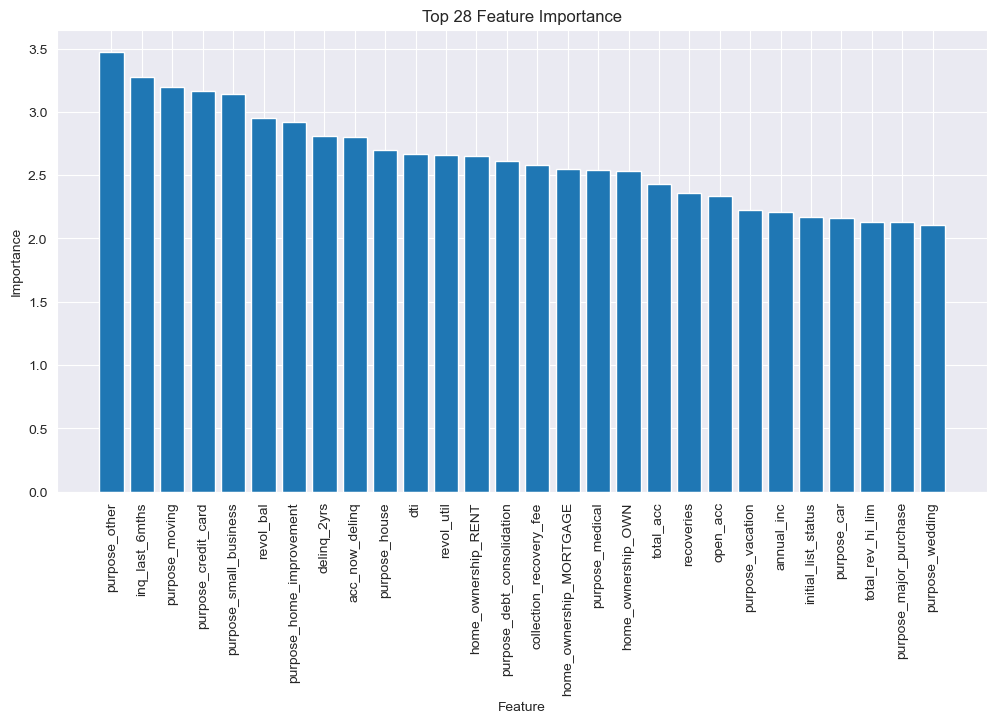

In [88]:
plot_feature_importance(best_rf_model, pca, pd.DataFrame(X_test_copy))

In [89]:
# compute SHAP values
explainer = shap.TreeExplainer(best_rf_model, X_train_copy)
shap_values = explainer(pd.DataFrame(X_test_copy), check_additivity= False)

100%|===================| 350133/350286 [44:07<00:01]        

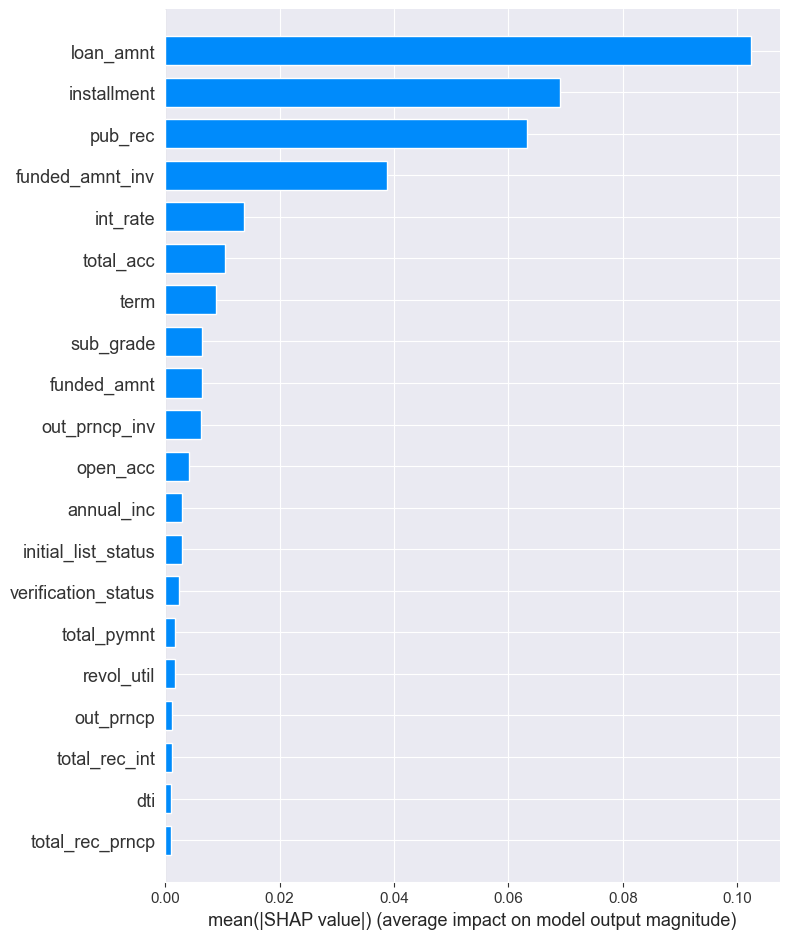

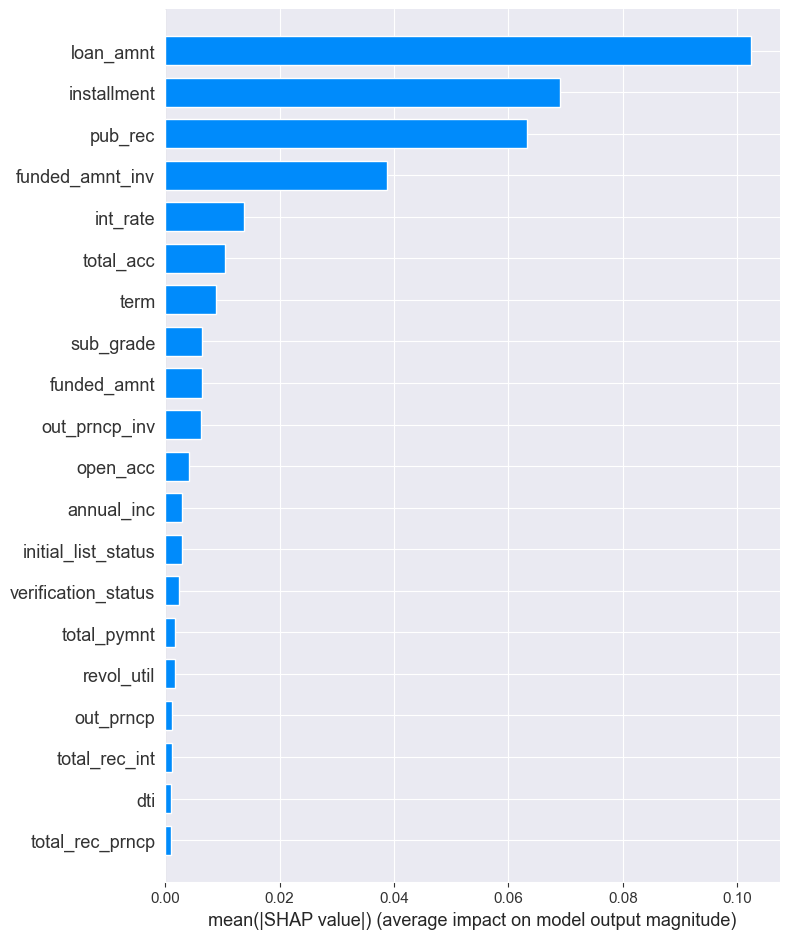

In [90]:
class_names = ['0','1']
shap.summary_plot(shap_values, pd.DataFrame(X_test_copy).values, plot_type='bar',
                  class_names=class_names, feature_names=pd.DataFrame(X_test_copy).columns.tolist())